# Generating dataset, preprocessing data and making train-test splti

Delta x =  tensor(0.0503)


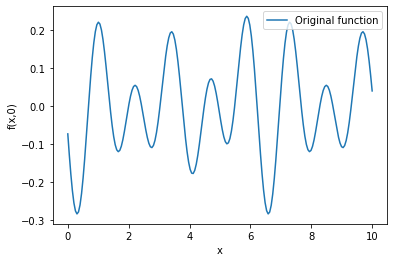

In [1]:
import math
import numpy as np
import torch
import matplotlib.pyplot as plt 
from tqdm import tqdm
import time
import cvxpy as cp
from cvxpylayers.torch import CvxpyLayer
import numpy.random as npr

torch.set_default_tensor_type(torch.DoubleTensor)

t = 0
N = 20
L = 2*math.pi
x = torch.linspace(0,10,200)
f = torch.tensor(0.0)
del_x = x[4]-x[3]
print("Delta x = ",del_x)

np.random.seed(0)
for i in range(1,N+1):
    A = np.random.uniform(low = -0.1, high = 0.1)
    w = np.random.uniform(low = -0.4, high = 0.4)
    phi = np.random.uniform(low = 0.0, high = 2*math.pi)
    l = np.random.choice([2,3,4,5])
    f = f + A*torch.sin(w*t + (2*math.pi*l*x)/L +phi)
    
plt.plot(x,f,label = 'Original function')
plt.xlabel('x')
plt.ylabel('f(x,0)')
plt.legend()

N = f.size(0)
testPct = 0.8    #train-test split
nTrain = int(N*(1.-testPct))

train_data = f[:nTrain]
test_data = f[nTrain:]

def preprocess(data):
    inputs = torch.DoubleTensor(data.size(0)-4,4)
    outputs = torch.DoubleTensor(data.size(0)-4,1)
    inputs = inputs.cuda()
    outputs = outputs.cuda()
    inputs = torch.autograd.Variable(inputs, requires_grad=True)
    outputs = torch.autograd.Variable(outputs, requires_grad=True)
    k = 0
    for i in range(2, data.size(0)-2):
        inputs.data[k] = torch.DoubleTensor([data[i-2],data[i-1],data[i+1],data[i+2]])
        outputs.data[k] = data[i]
        k = k+1
        
    return inputs,outputs

train_inputs,train_outputs = preprocess(train_data)
test_inputs,test_outputs = preprocess(test_data)

# Model Building and Training

In [2]:
class Reconstruct(torch.nn.Module):
    def __init__(self,seed = 0):
        super().__init__()
        torch.manual_seed(seed)
        self.fc1=torch.nn.Linear(4,16)
        self.fc2=torch.nn.Linear(16,4)
        self.D = torch.DoubleTensor([[1,1,1,1],[2*del_x,del_x,(-1)*del_x,(-2)*del_x],[4*pow(del_x,2),pow(del_x,2),pow(del_x,2),4*pow(del_x,2)],[8*pow(del_x,3),pow(del_x,3),(-1)*pow(del_x,3),(-8)*pow(del_x,3)]]).to("cuda")
        self.beta = torch.DoubleTensor([1,0,0,0]).to("cuda")
        z = cp.Variable(4)
        D = cp.Parameter((4,4))
        beta = cp.Parameter(4)
        x = cp.Parameter(4)
        objective = (cp.sum_squares(D @ z - beta))     #L2 norm square used
        constraints = [(z - x) <= 1e-1,
                       (z - x) >= -1e-1]
        problem = cp.Problem(cp.Minimize(objective),constraints)
        self.layer = CvxpyLayer(problem, parameters = [D,beta,x],
                      variables = [z])
        
    def forward(self,x):
        x = self.fc1(x)
        x = torch.nn.functional.elu(self.fc2(x))
        # when x is batched, repeat D and beta 
        if x.ndim == 2:
            batch_size = x.shape[0]
            return self.layer(self.D.repeat(batch_size, 1, 1), self.beta.repeat(batch_size, 1), x)[0]
        else:
            return self.layer(self.D, self.beta, x)[0]
        
def train(epoch,model,optimizer,train_inputs,train_outputs):
        
    optimizer.zero_grad()
    pred = model(train_inputs)
    loss = torch.nn.MSELoss()((pred*train_inputs).sum(1), train_outputs.flatten())
    loss.backward()
    optimizer.step()
    print('Epoch: {} \tLoss: {:.4f}'.format(epoch, loss))
    
    return loss.item()
    
def test(epoch,model,optimizer,test_inputs,test_outputs):
        
    pred = model(test_inputs)
    loss = torch.nn.MSELoss()((pred*test_inputs).sum(1), test_outputs.flatten())
        
    print('TEST SET RESULTS')
    print('Average loss: {:.4f}'.format(loss))
    
    return loss.item()

seed = 1

np.random.seed(seed)
torch.manual_seed(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

model = Reconstruct(seed = seed)
if torch.cuda.is_available():
    model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

test_loss = []
train_loss = []
epochs = 100
start = time.time()
for epoch in tqdm(range(epochs)):
    trainloss = train(epoch,model,optimizer,train_inputs,train_outputs)
    testloss = test(epoch,model,optimizer,test_inputs,test_outputs)
    test_loss.append(testloss)
    train_loss.append(trainloss)

print ("Training time : ",time.time()-start)
print("Test loss after 100 epochs:",test_loss[-1])
print("Training loss after 100 epochs:",train_loss[-1])

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

Epoch: 0 	Loss: 0.0370


  1%|▊                                                                                 | 1/100 [00:02<04:01,  2.44s/it]

TEST SET RESULTS
Average loss: 0.0190
Epoch: 1 	Loss: 0.0361


  2%|█▋                                                                                | 2/100 [00:03<02:54,  1.78s/it]

TEST SET RESULTS
Average loss: 0.0186
Epoch: 2 	Loss: 0.0351


  3%|██▍                                                                               | 3/100 [00:05<02:31,  1.56s/it]

TEST SET RESULTS
Average loss: 0.0181
Epoch: 3 	Loss: 0.0341


  4%|███▎                                                                              | 4/100 [00:06<02:20,  1.46s/it]

TEST SET RESULTS
Average loss: 0.0177
Epoch: 4 	Loss: 0.0332


  5%|████                                                                              | 5/100 [00:07<02:14,  1.41s/it]

TEST SET RESULTS
Average loss: 0.0173
Epoch: 5 	Loss: 0.0322


  6%|████▉                                                                             | 6/100 [00:08<02:09,  1.37s/it]

TEST SET RESULTS
Average loss: 0.0168
Epoch: 6 	Loss: 0.0313


  7%|█████▋                                                                            | 7/100 [00:10<02:05,  1.35s/it]

TEST SET RESULTS
Average loss: 0.0164
Epoch: 7 	Loss: 0.0303


  8%|██████▌                                                                           | 8/100 [00:11<02:02,  1.33s/it]

TEST SET RESULTS
Average loss: 0.0160
Epoch: 8 	Loss: 0.0294


  9%|███████▍                                                                          | 9/100 [00:12<02:00,  1.32s/it]

TEST SET RESULTS
Average loss: 0.0155
Epoch: 9 	Loss: 0.0285


 10%|████████                                                                         | 10/100 [00:14<01:58,  1.32s/it]

TEST SET RESULTS
Average loss: 0.0151
Epoch: 10 	Loss: 0.0276


 11%|████████▉                                                                        | 11/100 [00:15<01:56,  1.31s/it]

TEST SET RESULTS
Average loss: 0.0147
Epoch: 11 	Loss: 0.0267


 12%|█████████▋                                                                       | 12/100 [00:16<01:55,  1.31s/it]

TEST SET RESULTS
Average loss: 0.0143
Epoch: 12 	Loss: 0.0258


 13%|██████████▌                                                                      | 13/100 [00:18<01:53,  1.31s/it]

TEST SET RESULTS
Average loss: 0.0139
Epoch: 13 	Loss: 0.0249


 14%|███████████▎                                                                     | 14/100 [00:19<01:52,  1.31s/it]

TEST SET RESULTS
Average loss: 0.0135
Epoch: 14 	Loss: 0.0241


 15%|████████████▏                                                                    | 15/100 [00:20<01:51,  1.31s/it]

TEST SET RESULTS
Average loss: 0.0131
Epoch: 15 	Loss: 0.0232


 16%|████████████▉                                                                    | 16/100 [00:22<01:50,  1.31s/it]

TEST SET RESULTS
Average loss: 0.0127
Epoch: 16 	Loss: 0.0224


 17%|█████████████▊                                                                   | 17/100 [00:23<01:48,  1.31s/it]

TEST SET RESULTS
Average loss: 0.0123
Epoch: 17 	Loss: 0.0216


 18%|██████████████▌                                                                  | 18/100 [00:24<01:47,  1.31s/it]

TEST SET RESULTS
Average loss: 0.0119
Epoch: 18 	Loss: 0.0208


 19%|███████████████▍                                                                 | 19/100 [00:25<01:45,  1.31s/it]

TEST SET RESULTS
Average loss: 0.0116
Epoch: 19 	Loss: 0.0200


 20%|████████████████▏                                                                | 20/100 [00:27<01:44,  1.30s/it]

TEST SET RESULTS
Average loss: 0.0112
Epoch: 20 	Loss: 0.0192


 21%|█████████████████                                                                | 21/100 [00:28<01:42,  1.30s/it]

TEST SET RESULTS
Average loss: 0.0108
Epoch: 21 	Loss: 0.0184


 22%|█████████████████▊                                                               | 22/100 [00:29<01:41,  1.30s/it]

TEST SET RESULTS
Average loss: 0.0105
Epoch: 22 	Loss: 0.0177


 23%|██████████████████▋                                                              | 23/100 [00:31<01:40,  1.30s/it]

TEST SET RESULTS
Average loss: 0.0101
Epoch: 23 	Loss: 0.0169


 24%|███████████████████▍                                                             | 24/100 [00:32<01:39,  1.30s/it]

TEST SET RESULTS
Average loss: 0.0098
Epoch: 24 	Loss: 0.0162


 25%|████████████████████▎                                                            | 25/100 [00:33<01:37,  1.30s/it]

TEST SET RESULTS
Average loss: 0.0094
Epoch: 25 	Loss: 0.0155


 26%|█████████████████████                                                            | 26/100 [00:35<01:36,  1.30s/it]

TEST SET RESULTS
Average loss: 0.0091
Epoch: 26 	Loss: 0.0148


 27%|█████████████████████▊                                                           | 27/100 [00:36<01:34,  1.30s/it]

TEST SET RESULTS
Average loss: 0.0088
Epoch: 27 	Loss: 0.0141


 28%|██████████████████████▋                                                          | 28/100 [00:37<01:33,  1.30s/it]

TEST SET RESULTS
Average loss: 0.0085
Epoch: 28 	Loss: 0.0135


 29%|███████████████████████▍                                                         | 29/100 [00:38<01:32,  1.30s/it]

TEST SET RESULTS
Average loss: 0.0082
Epoch: 29 	Loss: 0.0128


 30%|████████████████████████▎                                                        | 30/100 [00:40<01:31,  1.31s/it]

TEST SET RESULTS
Average loss: 0.0078
Epoch: 30 	Loss: 0.0122


 31%|█████████████████████████                                                        | 31/100 [00:41<01:30,  1.31s/it]

TEST SET RESULTS
Average loss: 0.0076
Epoch: 31 	Loss: 0.0116


 32%|█████████████████████████▉                                                       | 32/100 [00:42<01:28,  1.31s/it]

TEST SET RESULTS
Average loss: 0.0073
Epoch: 32 	Loss: 0.0111


 33%|██████████████████████████▋                                                      | 33/100 [00:44<01:27,  1.31s/it]

TEST SET RESULTS
Average loss: 0.0070
Epoch: 33 	Loss: 0.0105


 34%|███████████████████████████▌                                                     | 34/100 [00:45<01:26,  1.30s/it]

TEST SET RESULTS
Average loss: 0.0067
Epoch: 34 	Loss: 0.0100


 35%|████████████████████████████▎                                                    | 35/100 [00:46<01:24,  1.31s/it]

TEST SET RESULTS
Average loss: 0.0064
Epoch: 35 	Loss: 0.0095


 36%|█████████████████████████████▏                                                   | 36/100 [00:48<01:23,  1.31s/it]

TEST SET RESULTS
Average loss: 0.0062
Epoch: 36 	Loss: 0.0090


 37%|█████████████████████████████▉                                                   | 37/100 [00:49<01:22,  1.30s/it]

TEST SET RESULTS
Average loss: 0.0059
Epoch: 37 	Loss: 0.0085


 38%|██████████████████████████████▊                                                  | 38/100 [00:50<01:20,  1.30s/it]

TEST SET RESULTS
Average loss: 0.0057
Epoch: 38 	Loss: 0.0081


 39%|███████████████████████████████▌                                                 | 39/100 [00:52<01:19,  1.30s/it]

TEST SET RESULTS
Average loss: 0.0055
Epoch: 39 	Loss: 0.0076


 40%|████████████████████████████████▍                                                | 40/100 [00:53<01:18,  1.30s/it]

TEST SET RESULTS
Average loss: 0.0052
Epoch: 40 	Loss: 0.0072


 41%|█████████████████████████████████▏                                               | 41/100 [00:54<01:17,  1.31s/it]

TEST SET RESULTS
Average loss: 0.0050
Epoch: 41 	Loss: 0.0068


 42%|██████████████████████████████████                                               | 42/100 [00:55<01:15,  1.30s/it]

TEST SET RESULTS
Average loss: 0.0048
Epoch: 42 	Loss: 0.0065


 43%|██████████████████████████████████▊                                              | 43/100 [00:57<01:14,  1.30s/it]

TEST SET RESULTS
Average loss: 0.0046
Epoch: 43 	Loss: 0.0061


 44%|███████████████████████████████████▋                                             | 44/100 [00:58<01:12,  1.30s/it]

TEST SET RESULTS
Average loss: 0.0044
Epoch: 44 	Loss: 0.0058


 45%|████████████████████████████████████▍                                            | 45/100 [00:59<01:11,  1.30s/it]

TEST SET RESULTS
Average loss: 0.0042
Epoch: 45 	Loss: 0.0055


 46%|█████████████████████████████████████▎                                           | 46/100 [01:01<01:10,  1.30s/it]

TEST SET RESULTS
Average loss: 0.0040
Epoch: 46 	Loss: 0.0052


 47%|██████████████████████████████████████                                           | 47/100 [01:02<01:08,  1.30s/it]

TEST SET RESULTS
Average loss: 0.0039
Epoch: 47 	Loss: 0.0049


 48%|██████████████████████████████████████▉                                          | 48/100 [01:03<01:07,  1.30s/it]

TEST SET RESULTS
Average loss: 0.0037
Epoch: 48 	Loss: 0.0046


 49%|███████████████████████████████████████▋                                         | 49/100 [01:05<01:06,  1.30s/it]

TEST SET RESULTS
Average loss: 0.0035
Epoch: 49 	Loss: 0.0044


 50%|████████████████████████████████████████▌                                        | 50/100 [01:06<01:04,  1.30s/it]

TEST SET RESULTS
Average loss: 0.0034
Epoch: 50 	Loss: 0.0042


 51%|█████████████████████████████████████████▎                                       | 51/100 [01:07<01:03,  1.30s/it]

TEST SET RESULTS
Average loss: 0.0032
Epoch: 51 	Loss: 0.0040


 52%|██████████████████████████████████████████                                       | 52/100 [01:08<01:02,  1.30s/it]

TEST SET RESULTS
Average loss: 0.0031
Epoch: 52 	Loss: 0.0038


 53%|██████████████████████████████████████████▉                                      | 53/100 [01:10<01:00,  1.30s/it]

TEST SET RESULTS
Average loss: 0.0029
Epoch: 53 	Loss: 0.0036


 54%|███████████████████████████████████████████▋                                     | 54/100 [01:11<00:59,  1.30s/it]

TEST SET RESULTS
Average loss: 0.0028
Epoch: 54 	Loss: 0.0034


 55%|████████████████████████████████████████████▌                                    | 55/100 [01:12<00:58,  1.30s/it]

TEST SET RESULTS
Average loss: 0.0027
Epoch: 55 	Loss: 0.0032


 56%|█████████████████████████████████████████████▎                                   | 56/100 [01:14<00:57,  1.30s/it]

TEST SET RESULTS
Average loss: 0.0025
Epoch: 56 	Loss: 0.0031


 57%|██████████████████████████████████████████████▏                                  | 57/100 [01:15<00:55,  1.30s/it]

TEST SET RESULTS
Average loss: 0.0024
Epoch: 57 	Loss: 0.0029


 58%|██████████████████████████████████████████████▉                                  | 58/100 [01:16<00:54,  1.30s/it]

TEST SET RESULTS
Average loss: 0.0023
Epoch: 58 	Loss: 0.0028


 59%|███████████████████████████████████████████████▊                                 | 59/100 [01:18<00:53,  1.32s/it]

TEST SET RESULTS
Average loss: 0.0022
Epoch: 59 	Loss: 0.0026


 60%|████████████████████████████████████████████████▌                                | 60/100 [01:19<00:52,  1.31s/it]

TEST SET RESULTS
Average loss: 0.0021
Epoch: 60 	Loss: 0.0025


 61%|█████████████████████████████████████████████████▍                               | 61/100 [01:20<00:50,  1.30s/it]

TEST SET RESULTS
Average loss: 0.0020
Epoch: 61 	Loss: 0.0024


 62%|██████████████████████████████████████████████████▏                              | 62/100 [01:21<00:49,  1.30s/it]

TEST SET RESULTS
Average loss: 0.0019
Epoch: 62 	Loss: 0.0023


 63%|███████████████████████████████████████████████████                              | 63/100 [01:23<00:48,  1.30s/it]

TEST SET RESULTS
Average loss: 0.0018
Epoch: 63 	Loss: 0.0022


 64%|███████████████████████████████████████████████████▊                             | 64/100 [01:24<00:46,  1.30s/it]

TEST SET RESULTS
Average loss: 0.0017
Epoch: 64 	Loss: 0.0021


 65%|████████████████████████████████████████████████████▋                            | 65/100 [01:25<00:45,  1.30s/it]

TEST SET RESULTS
Average loss: 0.0016
Epoch: 65 	Loss: 0.0020


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [01:27<00:44,  1.30s/it]

TEST SET RESULTS
Average loss: 0.0015
Epoch: 66 	Loss: 0.0019


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [01:28<00:42,  1.30s/it]

TEST SET RESULTS
Average loss: 0.0015
Epoch: 67 	Loss: 0.0018


 68%|███████████████████████████████████████████████████████                          | 68/100 [01:29<00:41,  1.31s/it]

TEST SET RESULTS
Average loss: 0.0014
Epoch: 68 	Loss: 0.0017


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [01:31<00:40,  1.30s/it]

TEST SET RESULTS
Average loss: 0.0013
Epoch: 69 	Loss: 0.0016


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [01:32<00:39,  1.30s/it]

TEST SET RESULTS
Average loss: 0.0012
Epoch: 70 	Loss: 0.0015


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [01:33<00:37,  1.30s/it]

TEST SET RESULTS
Average loss: 0.0012
Epoch: 71 	Loss: 0.0014


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [01:34<00:36,  1.30s/it]

TEST SET RESULTS
Average loss: 0.0011
Epoch: 72 	Loss: 0.0014


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [01:36<00:35,  1.30s/it]

TEST SET RESULTS
Average loss: 0.0010
Epoch: 73 	Loss: 0.0013


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [01:37<00:33,  1.30s/it]

TEST SET RESULTS
Average loss: 0.0010
Epoch: 74 	Loss: 0.0012


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [01:38<00:32,  1.30s/it]

TEST SET RESULTS
Average loss: 0.0009
Epoch: 75 	Loss: 0.0011


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [01:40<00:31,  1.30s/it]

TEST SET RESULTS
Average loss: 0.0009
Epoch: 76 	Loss: 0.0011


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [01:41<00:29,  1.30s/it]

TEST SET RESULTS
Average loss: 0.0008
Epoch: 77 	Loss: 0.0010


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [01:42<00:28,  1.30s/it]

TEST SET RESULTS
Average loss: 0.0008
Epoch: 78 	Loss: 0.0010


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [01:44<00:27,  1.30s/it]

TEST SET RESULTS
Average loss: 0.0007
Epoch: 79 	Loss: 0.0009


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [01:45<00:26,  1.30s/it]

TEST SET RESULTS
Average loss: 0.0007
Epoch: 80 	Loss: 0.0009


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [01:46<00:24,  1.30s/it]

TEST SET RESULTS
Average loss: 0.0007
Epoch: 81 	Loss: 0.0008


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [01:47<00:23,  1.30s/it]

TEST SET RESULTS
Average loss: 0.0006
Epoch: 82 	Loss: 0.0008


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [01:49<00:22,  1.30s/it]

TEST SET RESULTS
Average loss: 0.0006
Epoch: 83 	Loss: 0.0007


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [01:50<00:20,  1.30s/it]

TEST SET RESULTS
Average loss: 0.0006
Epoch: 84 	Loss: 0.0007


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [01:51<00:19,  1.30s/it]

TEST SET RESULTS
Average loss: 0.0005
Epoch: 85 	Loss: 0.0007


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [01:53<00:18,  1.30s/it]

TEST SET RESULTS
Average loss: 0.0005
Epoch: 86 	Loss: 0.0006


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [01:54<00:16,  1.30s/it]

TEST SET RESULTS
Average loss: 0.0005
Epoch: 87 	Loss: 0.0006


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [01:55<00:15,  1.31s/it]

TEST SET RESULTS
Average loss: 0.0004
Epoch: 88 	Loss: 0.0006


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [01:57<00:14,  1.30s/it]

TEST SET RESULTS
Average loss: 0.0004
Epoch: 89 	Loss: 0.0005


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [01:58<00:13,  1.30s/it]

TEST SET RESULTS
Average loss: 0.0004
Epoch: 90 	Loss: 0.0005


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [01:59<00:11,  1.30s/it]

TEST SET RESULTS
Average loss: 0.0004
Epoch: 91 	Loss: 0.0005


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [02:00<00:10,  1.30s/it]

TEST SET RESULTS
Average loss: 0.0003
Epoch: 92 	Loss: 0.0005


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [02:02<00:09,  1.30s/it]

TEST SET RESULTS
Average loss: 0.0003
Epoch: 93 	Loss: 0.0004


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [02:03<00:07,  1.30s/it]

TEST SET RESULTS
Average loss: 0.0003
Epoch: 94 	Loss: 0.0004


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [02:04<00:06,  1.30s/it]

TEST SET RESULTS
Average loss: 0.0003
Epoch: 95 	Loss: 0.0004


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [02:06<00:05,  1.30s/it]

TEST SET RESULTS
Average loss: 0.0003
Epoch: 96 	Loss: 0.0004


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [02:07<00:03,  1.30s/it]

TEST SET RESULTS
Average loss: 0.0003
Epoch: 97 	Loss: 0.0004


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [02:08<00:02,  1.30s/it]

TEST SET RESULTS
Average loss: 0.0002
Epoch: 98 	Loss: 0.0003


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [02:10<00:01,  1.30s/it]

TEST SET RESULTS
Average loss: 0.0002
Epoch: 99 	Loss: 0.0003


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:11<00:00,  1.31s/it]

TEST SET RESULTS
Average loss: 0.0002
Training time :  131.40061450004578
Test loss after 100 epochs: 0.00022014950145305204
Training loss after 100 epochs: 0.0003288944926836068


# Plotting outputs

Text(0.5, 1.0, 'Sum of 2nd order moments for 2 FC layers with moment constraints')

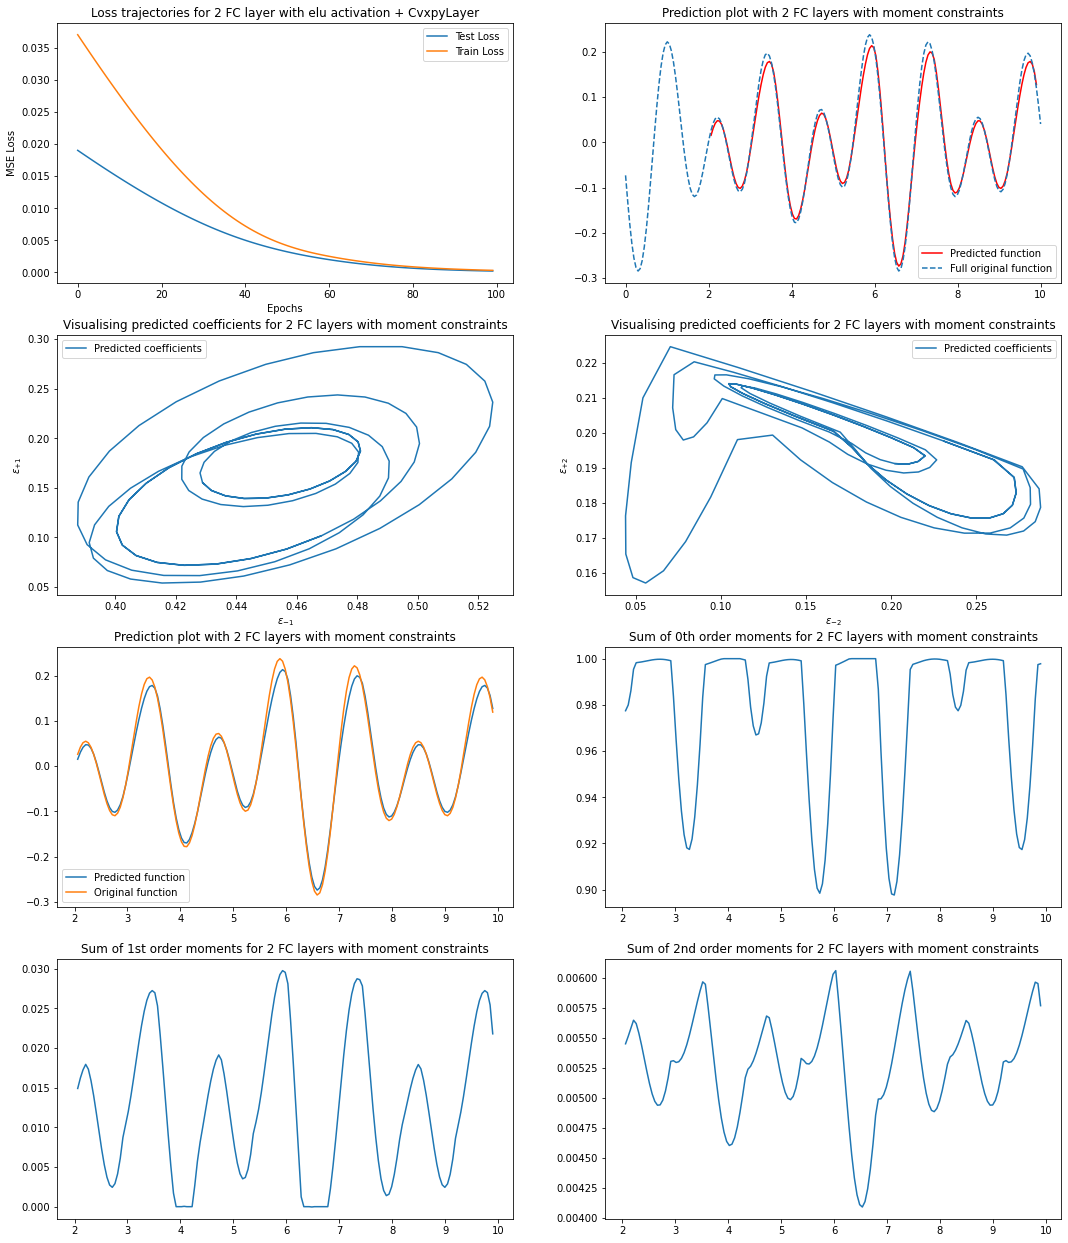

In [3]:
fig, ax = plt.subplots(4, 2)
fig.set_figwidth(18)
fig.set_figheight(22)

ax[0,0].plot(torch.DoubleTensor(test_loss),label = "Test Loss")
ax[0,0].plot(torch.DoubleTensor(train_loss),label = "Train Loss")
ax[0,0].legend(loc = "upper right")
ax[0,0].set_xlabel("Epochs")
ax[0,0].set_ylabel("MSE Loss")
ax[0,0].set_title("Loss trajectories for 2 FC layer with elu activation + CvxpyLayer")

pred = model(test_inputs)
pred = pred.cpu().detach().numpy()
test_inputs = test_inputs.to('cpu').detach().numpy()
test_outputs = test_outputs.to('cpu').detach().numpy()

ax[0,1].plot(x[-159:-2],(pred*test_inputs).sum(1),label = 'Predicted function',color = 'red')
ax[0,1].plot(x,f,label = 'Full original function',linestyle = 'dashed')
ax[0,1].legend()
ax[0,1].set_title("Prediction plot with 2 FC layers with moment constraints")

ax[1,0].plot(pred[:,1],pred[:,2],label = 'Predicted coefficients')
ax[1,0].legend()
ax[1,0].set_xlabel('$\epsilon_{-1}$')
ax[1,0].set_ylabel('$\epsilon_{+1}$')
ax[1,0].set_title("Visualising predicted coefficients for 2 FC layers with moment constraints")

ax[1,1].plot(pred[:,0],pred[:,3],label = 'Predicted coefficients')
ax[1,1].legend()
ax[1,1].set_xlabel('$\epsilon_{-2}$')
ax[1,1].set_ylabel('$\epsilon_{+2}$')
ax[1,1].set_title("Visualising predicted coefficients for 2 FC layers with moment constraints")

ax[2,0].plot(x[-159:-2],(pred*test_inputs).sum(1),label = 'Predicted function')
ax[2,0].plot(x[-159:-2],test_outputs.flatten(),label = 'Original function')
ax[2,0].legend()
ax[2,0].set_title("Prediction plot with 2 FC layers with moment constraints")

ax[2,1].plot(x[-159:-2],pred[:,0]+pred[:,1]+pred[:,2]+pred[:,3])
ax[2,1].set_title("Sum of 0th order moments for 2 FC layers with moment constraints")

ax[3,0].plot(x[-159:-2],2*del_x*pred[:,0]+del_x*pred[:,1]+(-1)*del_x*pred[:,2]+(-2)*del_x*pred[:,3])
ax[3,0].set_title("Sum of 1st order moments for 2 FC layers with moment constraints")

ax[3,1].plot(x[-159:-2],4*pow(del_x,2)*pred[:,0]+pow(del_x,2)*pred[:,1]+pow(del_x,2)*pred[:,2]+4*pow(del_x,2)*pred[:,3])
ax[3,1].set_title("Sum of 2nd order moments for 2 FC layers with moment constraints")

#ax[4,0].plot(x[-159:-2],8*pow(del_x,3)*pred[:,0]+pow(del_x,3)*pred[:,1]+(-1)*pow(del_x,3)*pred[:,2]+(-8)*pow(del_x,3)*pred[:,3])
#ax[4,0].set_title("Sum of 3rd order moments for 2 FC layers with moment constraints")

# Storing predicted coefficients in text file

In [13]:
f = open("Predicted_coefficients_test_set_Cvxpy.txt",'w')
for i in pred:
    f.write(str(i) + "\n")
f.close()